In [1]:
import pandas as pd

In [2]:
prot_df = pd.read_csv('train_data.csv')
prot_df

,sequences,label
0,RRWWRRWRRW,0
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1
3,GLFDVIKKVAAVIGGL,1
4,VAKLLAKLAKKVL,1
...,...,...
1373,LLKLLKWLLKLLK,0
1374,GFKDWIKGAAKKLIKTVAANIANQ,0
1375,ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,0
1376,FISAIASFLGKFL,1


In [3]:
# Following https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

In [4]:
# Turn all sequences into kmers (k=3)
from collections import Counter  # Might as well count frequency
kmers = Counter()
for seq in prot_df['sequences'].values:
    for kmer_a, kmer_b, kmer_c in zip(seq, seq[1:], seq[2:]):
        kmer = ''.join([kmer_a, kmer_b, kmer_c])
        kmers[kmer] += 1
list(kmers.items())[:5]

[('RRW', 17), ('RWW', 5), ('WWR', 4), ('WRR', 11), ('RWR', 10)]

In [5]:
word_to_ix = {kmer: i for i, kmer in enumerate(kmers)}
ix_to_word = {i: word for word, i in word_to_ix.items()}
embeds = nn.Embedding(len(word_to_ix), 5)  # x words in vocab, y=5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["RRW"]], dtype=torch.long)
rrw_embed = embeds(lookup_tensor)
rrw_embed

tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784]],
       grad_fn=<EmbeddingBackward0>)

In [10]:
ix_to_word = {i: word for word, i in word_to_ix.items()}

In [6]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
vocab = set(kmers)
vocab_size = len(vocab)
kmer_len = 3

data = []

for seq in prot_df['sequences'].values:
    for i in range(0, len(seq) - CONTEXT_SIZE*kmer_len):
        kmer_minus_2 = seq[i:i+kmer_len]
        kmer_minus_1 = seq[i+1:i+kmer_len+1]
        kmer_i = seq[i+2:i+kmer_len+2]
        kmer_plus_1 = seq[i+3:i+kmer_len+3]
        kmer_plus_2 = seq[i+4:i+kmer_len+4]
        data.append(([kmer_minus_2, kmer_minus_1, kmer_plus_1, kmer_plus_2], kmer_i))
data[:5]

[(['RRW', 'RWW', 'WRR', 'RRW'], 'WWR'),
 (['RWW', 'WWR', 'RRW', 'RWR'], 'WRR'),
 (['WWR', 'WRR', 'RWR', 'WRR'], 'RRW'),
 (['WRR', 'RRW', 'WRR', 'RRW'], 'RWR'),
 (['GWK', 'WKS', 'SVF', 'VFR'], 'KSV')]

In [13]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 512)
        self.activation_function1 = nn.ReLU()
        
        #out: 1 x vocab_size
        self.linear2 = nn.Linear(512, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)

In [20]:
model = CBOW(vocab_size, 100)
model

CBOW(
  (embeddings): Embedding(5647, 100)
  (linear1): Linear(in_features=100, out_features=512, bias=True)
  (activation_function1): ReLU()
  (linear2): Linear(in_features=512, out_features=5647, bias=True)
  (activation_function2): LogSoftmax(dim=-1)
)

In [18]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

In [21]:
import numpy as np
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
num_train = int(0.8*len(data))
num_test = len(data) - num_train
print(f'{num_train=} {num_test=}')
train_data, test_data = torch.utils.data.random_split(data, [num_train, num_test], generator=torch.Generator().manual_seed(42))

#TRAINING
for epoch in range(1000):
    print(f'Starting epoch {epoch}')
    total_loss = 0

    for context, target in train_data:
        context_vector = make_context_vector(context, word_to_ix)
        log_probs = model(context_vector)
        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))
    print(f'Loss: {total_loss:,.2f}')
    if np.isnan(float(f'{total_loss}')):
        break

    correct_guesses = 0
    for context, target in test_data:
        context_vector = make_context_vector(context, word_to_ix)
        log_probs = model(context_vector)
        guessed = ix_to_word[torch.argmax(log_probs[0]).item()]
        if guessed == target:
            correct_guesses += 1
    print(f'Done with epoch {epoch} and got accuracy {correct_guesses}/{len(test_data)}={100*(correct_guesses / len(test_data)):.5f}%')

    #optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

num_train=19665 num_test=4917
Starting epoch 0
Loss: 172,304.08
Done with epoch 0 and got accuracy 2/4917=0.04068%
Starting epoch 1
Loss: 137,471.70
Done with epoch 1 and got accuracy 115/4917=2.33882%
Starting epoch 2
Loss: 114,107.71
Done with epoch 2 and got accuracy 314/4917=6.38601%
Starting epoch 3
Loss: 86,672.50
Done with epoch 3 and got accuracy 851/4917=17.30730%
Starting epoch 4
Loss: 59,412.47
Done with epoch 4 and got accuracy 1279/4917=26.01180%
Starting epoch 5
Loss: 38,962.85
Done with epoch 5 and got accuracy 1446/4917=29.40818%
Starting epoch 6
Loss: 26,023.90
Done with epoch 6 and got accuracy 1546/4917=31.44194%
Starting epoch 7
Loss: 18,403.68
Done with epoch 7 and got accuracy 1644/4917=33.43502%
Starting epoch 8
Loss: 13,448.64
Done with epoch 8 and got accuracy 1711/4917=34.79764%
Starting epoch 9
Loss: 10,056.56
Done with epoch 9 and got accuracy 1783/4917=36.26195%


KeyboardInterrupt: ignored

In [38]:
def get_embeddings(seq):
    # Convert to kmers and lookup
    kmers = []
    for i in range(0, len(seq) - 2):
        kmer = seq[i:i+3]
        kmers.append(kmer)
    return model.embeddings(torch.tensor([word_to_ix[kmer] for kmer in kmers])).cpu().detach().numpy()

# Test
get_embeddings('RRWR')

array([[-2.90291399e-01,  1.93707812e+00,  6.79152548e-01,
        -9.33501482e-01,  1.94206536e+00, -8.96599174e-01,
         5.03463149e-01,  1.27361402e-01,  1.14719105e+00,
        -7.92716622e-01, -8.13505173e-01, -7.23141432e-01,
         1.37135863e+00,  7.93440878e-01, -1.00572240e+00,
        -3.30288261e-01,  7.26157129e-01, -7.70293355e-01,
        -8.46399128e-01,  6.93229616e-01, -1.11703873e-01,
        -2.10047826e-01, -6.09683692e-02, -1.53602317e-01,
        -6.74875736e-01, -1.24039257e+00, -6.65199995e-01,
        -1.46732068e+00, -1.48387742e+00, -2.35259429e-01,
         1.09206176e+00,  1.20691442e+00,  1.94540739e+00,
        -1.85505569e+00,  7.49672353e-02, -8.67670417e-01,
         7.49746740e-01, -5.17371535e-01, -1.05235052e+00,
         1.17955461e-01,  8.77938628e-01,  9.05105293e-01,
        -1.29198301e+00, -6.17393136e-01,  9.48847294e-01,
        -2.06430554e+00, -1.10091865e+00, -6.74853921e-02,
         4.38624620e-01,  2.06952170e-02, -1.15158305e-0

In [39]:
prot_df['embeddings'] = prot_df['sequences'].map(get_embeddings)
prot_df

,sequences,label,embeddings,mean_embeddings,max_embeddings,sum_embeddings
0,RRWWRRWRRW,0,"[[-0.2902914, 1.9370781, 0.67915255, -0.933501...","[tensor(-0.0890, grad_fn=<UnbindBackward0>), t...","([tensor(1.2108, grad_fn=<UnbindBackward0>), t...","[tensor(-0.7120, grad_fn=<UnbindBackward0>), t..."
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0,"[[-1.7640558, -0.39078295, 1.0376004, 0.005438...","[tensor(0.0755, grad_fn=<UnbindBackward0>), te...","([tensor(1.5615, grad_fn=<UnbindBackward0>), t...","[tensor(1.8122, grad_fn=<UnbindBackward0>), te..."
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1,"[[-0.695904, 0.1762659, 2.404104, 0.29795656, ...","[tensor(-0.0968, grad_fn=<UnbindBackward0>), t...","([tensor(1.7448, grad_fn=<UnbindBackward0>), t...","[tensor(-3.0970, grad_fn=<UnbindBackward0>), t..."
3,GLFDVIKKVAAVIGGL,1,"[[1.3044345, -0.20382315, -0.06013742, -0.9604...","[tensor(-0.4105, grad_fn=<UnbindBackward0>), t...","([tensor(1.3044, grad_fn=<UnbindBackward0>), t...","[tensor(-5.7465, grad_fn=<UnbindBackward0>), t..."
4,VAKLLAKLAKKVL,1,"[[-0.22292744, -1.0182463, -0.37543008, 0.3764...","[tensor(0.3043, grad_fn=<UnbindBackward0>), te...","([tensor(1.5840, grad_fn=<UnbindBackward0>), t...","[tensor(3.3469, grad_fn=<UnbindBackward0>), te..."
...,...,...,...,...,...,...
1373,LLKLLKWLLKLLK,0,"[[0.08275411, 1.175182, -0.40921593, 1.9827316...","[tensor(0.3615, grad_fn=<UnbindBackward0>), te...","([tensor(1.5840, grad_fn=<UnbindBackward0>), t...","[tensor(3.9763, grad_fn=<UnbindBackward0>), te..."
1374,GFKDWIKGAAKKLIKTVAANIANQ,0,"[[0.020692516, -1.6813531, -0.78388935, 0.7739...","[tensor(-0.1815, grad_fn=<UnbindBackward0>), t...","([tensor(1.4040, grad_fn=<UnbindBackward0>), t...","[tensor(-3.9931, grad_fn=<UnbindBackward0>), t..."
1375,ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,0,"[[0.04293945, 0.3086278, 0.25484914, 0.3692831...","[tensor(-0.1153, grad_fn=<UnbindBackward0>), t...","([tensor(1.8791, grad_fn=<UnbindBackward0>), t...","[tensor(-5.4187, grad_fn=<UnbindBackward0>), t..."
1376,FISAIASFLGKFL,1,"[[0.73081523, 1.3351052, -0.11997716, -0.63287...","[tensor(0.6636, grad_fn=<UnbindBackward0>), te...","([tensor(1.6886, grad_fn=<UnbindBackward0>), t...","[tensor(7.2997, grad_fn=<UnbindBackward0>), te..."


In [40]:
prot_df['mean_embeddings'] = prot_df['embeddings'].map(lambda x: x.mean(0))
prot_df['max_embeddings'] = prot_df['embeddings'].map(lambda x: x.max(0))
prot_df['sum_embeddings'] = prot_df['embeddings'].map(lambda x: x.sum(0))

In [41]:
prot_df

,sequences,label,embeddings,mean_embeddings,max_embeddings,sum_embeddings
0,RRWWRRWRRW,0,"[[-0.2902914, 1.9370781, 0.67915255, -0.933501...","[-0.089005716, 0.31397146, 0.1429511, -0.47421...","[1.2107568, 1.9370781, 0.67915255, 0.12821205,...","[-0.7120457, 2.5117717, 1.1436088, -3.7937572,..."
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0,"[[-1.7640558, -0.39078295, 1.0376004, 0.005438...","[0.075508185, -0.091168456, 0.03975719, 0.3057...","[1.5614979, 1.7101154, 2.3459177, 2.519493, 1....","[1.8121965, -2.1880429, 0.9541725, 7.338078, -..."
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1,"[[-0.695904, 0.1762659, 2.404104, 0.29795656, ...","[-0.09678085, -0.123838075, 0.06888337, -0.226...","[1.7448324, 3.5165718, 2.9715054, 1.1049645, 1...","[-3.0969872, -3.9628184, 2.2042677, -7.2461367..."
3,GLFDVIKKVAAVIGGL,1,"[[1.3044345, -0.20382315, -0.06013742, -0.9604...","[-0.41046733, -0.38465467, -0.35819837, 0.0416...","[1.3044345, 1.4179423, 0.83870536, 1.3837191, ...","[-5.7465425, -5.385165, -5.014777, 0.5824898, ..."
4,VAKLLAKLAKKVL,1,"[[-0.22292744, -1.0182463, -0.37543008, 0.3764...","[0.30426392, -0.5542178, -0.3586683, 0.1175601...","[1.5840265, 0.6554092, 1.6594921, 1.124666, 1....","[3.346903, -6.096396, -3.9453511, 1.2931617, 2..."
...,...,...,...,...,...,...
1373,LLKLLKWLLKLLK,0,"[[0.08275411, 1.175182, -0.40921593, 1.9827316...","[0.36148623, 0.40688464, -0.22980732, 0.281311...","[1.5840265, 2.0322587, 1.1487348, 1.9827316, 1...","[3.9763484, 4.475731, -2.5278804, 3.0944285, -..."
1374,GFKDWIKGAAKKLIKTVAANIANQ,0,"[[0.020692516, -1.6813531, -0.78388935, 0.7739...","[-0.18150276, -0.4551161, 0.22078276, -0.01889...","[1.4039764, 1.8907503, 1.7139108, 1.2811229, 1...","[-3.9930606, -10.012554, 4.8572206, -0.4157598..."
1375,ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,0,"[[0.04293945, 0.3086278, 0.25484914, 0.3692831...","[-0.11529216, -0.16205625, 0.0868803, 0.196775...","[1.8791405, 2.6419275, 2.5672975, 1.9701006, 3...","[-5.4187317, -7.616644, 4.083374, 9.248439, 5...."
1376,FISAIASFLGKFL,1,"[[0.73081523, 1.3351052, -0.11997716, -0.63287...","[0.66360813, 0.30228412, -0.084562235, -0.1454...","[1.6886287, 2.268923, 2.1941576, 1.452939, 1.2...","[7.2996893, 3.3251252, -0.93018454, -1.5996313..."


In [42]:
mean_embeddings = pd.DataFrame(prot_df['mean_embeddings'].tolist())
max_embeddings = pd.DataFrame(prot_df['max_embeddings'].tolist())
sum_embeddings = pd.DataFrame(prot_df['sum_embeddings'].tolist())
all_embeddings = mean_embeddings.merge(max_embeddings, left_index=True, right_index=True).merge(sum_embeddings, left_index=True, right_index=True)
all_embeddings

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,90,91,92,93,94,95,96,97,98,99
0,-0.089006,0.313971,0.142951,-0.474220,0.677447,-0.691783,0.510765,-0.156296,1.011262,-0.577389,...,-7.619872,-2.060076,-0.486328,-6.642022,2.266807,-1.386579,-2.161902,4.014975,3.315075,-2.667197
1,0.075508,-0.091168,0.039757,0.305753,-0.115349,-0.217259,-0.188192,-0.057035,-0.262796,-0.126928,...,-4.067432,-0.144349,1.211608,-8.931470,-3.626008,-6.065169,-2.748689,-7.720950,-2.363174,-8.877586
2,-0.096781,-0.123838,0.068883,-0.226442,-0.027782,0.062723,0.057078,0.013071,-0.083117,-0.190217,...,-1.791161,0.020606,-8.047579,2.732175,7.434629,19.262529,-1.330494,0.668677,-1.312967,-3.210135
3,-0.410467,-0.384655,-0.358198,0.041606,0.248289,-0.163534,0.298316,-0.219879,0.065991,-0.184032,...,-1.635078,0.025217,-5.118148,2.543669,-0.710972,-5.746690,1.511404,-2.507231,-0.949445,1.876193
4,0.304264,-0.554218,-0.358668,0.117560,0.187843,0.274448,-0.160230,0.036500,-0.054515,0.626563,...,-4.058511,0.292663,1.922134,4.475411,-0.794655,3.250248,-1.991314,-7.815462,2.157642,4.606894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,0.361486,0.406885,-0.229807,0.281312,-0.585311,0.302232,-0.095214,-0.402692,0.445241,-0.264056,...,-4.102316,-3.675536,-12.071134,6.254900,-6.272805,-0.943505,1.050292,-7.788260,2.127580,-6.435973
1374,-0.181503,-0.455116,0.220783,-0.018898,-0.066042,0.137952,-0.200215,0.120377,0.211801,-0.107101,...,7.928236,4.792704,0.002733,1.152517,-0.191044,2.892341,7.478722,5.963643,-1.920827,5.816436
1375,-0.115292,-0.162056,0.086880,0.196775,0.116600,-0.121327,0.002137,-0.136498,-0.018872,-0.093803,...,4.289863,-1.881694,-11.139684,-3.873785,-4.949148,-4.343216,1.922413,-13.880639,5.960995,3.634413
1376,0.663608,0.302284,-0.084562,-0.145421,-0.130884,-0.156489,-0.077256,0.424855,0.012335,-0.353556,...,1.909136,4.771355,-2.420512,3.603353,3.758649,-1.031259,1.739598,-5.030833,0.167834,1.624283


## Lets do a RandomForest with these embeddings

In [43]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=1_000, 
                             max_depth=10,
                             random_state=42)

from sklearn.model_selection import train_test_split

X, y = all_embeddings, prot_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.71      0.73      0.72       150
           1       0.67      0.63      0.65       126

    accuracy                           0.69       276
   macro avg       0.69      0.68      0.68       276
weighted avg       0.69      0.69      0.69       276



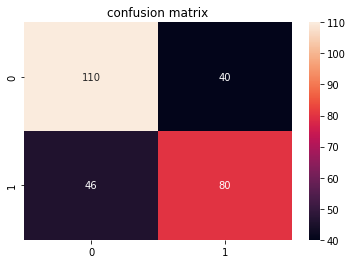

In [45]:
# Fit RandomForestClassifier
rfc.fit(X_train, y_train)
# Predict the test set labels
y_pred = rfc.predict(X_test)

# Analyze results
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('confusion matrix')

print(classification_report(y_test,y_pred))

Baseline results as shown above. Accuracy 69%, precision is 71-67%, recall is 73-63%. Seems to predict 0's better than 1's. Lots of room for improvement :) 